# Optimization Methods - Momentum & Adam

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import math
import sklearn
import sklearn.datasets
import time

from tools.activation_function import sigmoid, sigmoid_derivative, ReLU, ReLU_derivative, tanh, tanh_derivative
from tools.nn_function import forward_propagation, cost_function, backward_propagation, update_derivatives, plot_cost, predict

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [22]:
# ====== Momentum ====== 
def init_velocity (params, L_len):
    # 创建和 W, b一样的矩阵, 创建 Velocity
    """
    np.zeros_like([[5, 1, 1], [5, 1, 1]])
    return [[0 0 0], [0 0 0]]
    """
    Velocity = {}
    for i in range(1, L_len):
        Velocity['dJ_dW' + str(i)] = np.zeros_like(params['W' + str(i)])
        Velocity['dJ_db' + str(i)] = np.zeros_like(params['b' + str(i)])
    return Velocity

def update_derivatives_momentum (params, grads, alpha, L_len, Velocity, beta = 0.9):
    """
    𝑉_𝑑𝑤 = 𝛽 𝑉_𝑑𝑤 + (1−𝛽) 𝑑𝐽_𝑑𝑤  
    𝑤=𝑤 − 𝛼 𝑉_𝑑𝑤
    """
    for l in range(1, L_len):
        # dJ_dw, dJ_dw
        dJ_dW = grads['dJ_dW' + str(l)]
        dJ_db = grads['dJ_db'+ str(l)]
        
        # V_dJ_dw, V_dJ_db
        V_dJ_dw = Velocity['dJ_dW' + str(l)]
        V_dJ_db = Velocity['dJ_db' + str(l)]
        
        # V_dJ_dw = beta * V_dJ_dw + (1 - beta) * dJ_dw
        # V_dJ_db = beta * V_dJ_db + (1 - beta) * dJ_db
        Velocity['dJ_dW' + str(l)] = beta * V_dJ_dw + (1 - beta) * dJ_dW
        Velocity['dJ_db' + str(l)] = beta * V_dJ_db + (1 - beta) * dJ_db

        params['W' + str(l)] -= alpha * Velocity['dJ_dW' + str(l)]
        params['b' + str(l)] -= alpha * Velocity['dJ_db' + str(l)]
    
    return params
# ====== Momentum ====== 

In [23]:
# ====== Adam ====== 
def init_Adam (params, L_len):
    # 1. 创建Velocity, 创建Square
    Velocity, Square = {}, {}
    
    # 2. 创建初始化值为0 和 每层params.weights, params.bias一样尺寸
    for l in range(1, L_len):
        W, b = params['W' + str(l)], params['b' + str(l)]
        
        Velocity['dJ_dW' + str(l)] = np.zeros_like(W)
        Velocity['dJ_db' + str(l)] = np.zeros_like(b)
        
        Square['dJ_dW' + str(l)] = np.zeros_like(W)
        Square['dJ_db' + str(l)] = np.zeros_like(b)
    
    return Velocity, Square


def update_derivatives_Adam (params, grads, alpha, L_len, Velocity, Square, beta1 = 0.9, beta2 = 0.9, t = 2):
    Velocity_correct = {}
    Square_correct = {}
    epsilon = 1e-8
    
    for l in range(1, L_len):
        dJ_dW_i = 'dJ_dW' + str(l)
        dJ_db_i = 'dJ_db' + str(l)
        
        # 1. derivatives
        dJ_dW = grads[dJ_dW_i]
        dJ_db = grads[dJ_db_i]
        
        """
        𝑉𝑑𝑤=𝛽1 * V𝑑𝑤 + (1−𝛽1)  𝑑𝐽𝑑𝑤 
        𝑆𝑑𝑤=𝛽2 * 𝑆𝑑𝑤 + (1−𝛽2)  (𝑑𝐽𝑑𝑤)^2
        """
        # 2. V_dJ_dW, V_dJ_db
        Velocity[dJ_dW_i] = beta1 * Velocity[dJ_dW_i] + (1 - beta1) * dJ_dW
        Velocity[dJ_db_i] = beta1 * Velocity[dJ_db_i] + (1 - beta1) * dJ_db
        
        # 3. S_dJ_dW, S_dJ_db
        Square[dJ_dW_i] = beta2 * Square[dJ_dW_i] + (1 - beta2) * np.power(dJ_dW, 2)
        Square[dJ_db_i] = beta2 * Square[dJ_db_i] + (1 - beta2) * np.power(dJ_db, 2)
        
        # 4. Velocity_correct: V_dJ_dW, V_dJ_db
        """
        𝑉𝑐𝑜𝑟𝑟𝑒𝑐𝑡_𝑑𝐽_𝑑𝑤 = V_𝑑𝐽_𝑑𝑤 / 1−(𝛽1)^𝑡
        𝑆𝑐𝑜𝑟𝑟𝑒𝑐𝑡_𝑑𝐽_𝑑𝑤 = S_𝑑𝐽_𝑑𝑤 / 1−(𝛽2)^𝑡
        """
        Velocity_correct[dJ_dW_i] = Velocity[dJ_dW_i] / (1 - np.power(beta1, t))
        Velocity_correct[dJ_db_i] = Velocity[dJ_db_i] / (1 - np.power(beta1, t))
        
        # 5. Square_correct: S_dJ_dW, S_dJ_db
        Square_correct[dJ_dW_i] = Square[dJ_dW_i] / (1 - np.power(beta2, t))
        Square_correct[dJ_db_i] = Square[dJ_db_i] / (1 - np.power(beta2, t))
        
        # 6. Update derivatives
        """
        𝑤 −= a * Velocity_correct / e + sqrt(Square_correct)
        """
        params['W' + str(l)] -= alpha * Velocity_correct[dJ_dW_i] / (epsilon + np.sqrt(Square_correct[dJ_dW_i]))
        params['b' + str(l)] -= alpha * Velocity_correct[dJ_db_i] / (epsilon + np.sqrt(Square_correct[dJ_db_i]))
        
    return params
        
        

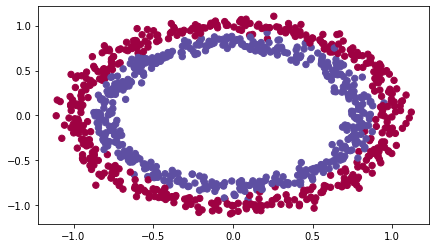

In [24]:
def load_dataset ():
    # training set
    np.random.seed(1)
    train_X, train_Y = sklearn.datasets.make_circles(n_samples=1000, noise=.05)
    # testing set
    np.random.seed(2)
    test_X, test_Y = sklearn.datasets.make_circles(n_samples=100, noise=.05)
    # plot
    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
    # handle data
    train_X, test_X = train_X.T, test_X.T
    train_Y = train_Y.reshape((1, train_Y.shape[0]))
    test_Y = test_Y.reshape((1, test_Y.shape[0]))
    
    return train_X, train_Y, test_X, test_Y
train_X, train_Y, test_X, test_Y = load_dataset()

class NN_Model ():
    def __init__(self, X, y, Layers, alpha = 0.1, iterations = 5000):
        self.X = X
        self.y = y
        
        self.Layers = Layers
        self.L_len = len(Layers)
        self.m = X.shape[1]
        # hyperparameters:
        self.alpha = alpha
        self.iterations = iterations
    
    def init_parameters_he (self):
        np.random.seed(0)
        parameters = {}
        for i in range(1, len(self.Layers)):
            # 缩放因子
            he = np.sqrt(2. / self.Layers[i - 1])
            parameters['W' + str(i)] = np.random.randn(self.Layers[i - 1], self.Layers[i]) * he
            parameters['b' + str(i)] = np.zeros(shape = (self.Layers[i], 1))
        return parameters

    def training_GD (self):
        X, y = self.X, self.y
        L_len, alpha = self.L_len, self.alpha
        J_arr = []
        print('======= 未优化 ======')
        # 1. init parameters
        params = self.init_parameters_he()
        for i in range(self.iterations):
            # 2. Forward propagation
            A = forward_propagation(X, params)
            # 3. Loss
            if i % 100 == 0:
                J_arr.append(cost_function(A, y))
            # 4. backward_propagation
            grads = backward_propagation (A, y, params)
            # 5. update_derivatives
            params = update_derivatives (params, grads, alpha, L_len)
        plot_cost (J_arr, alpha)
        print('未优化 - 代价函数: ', J_arr[-1])
        return params     
    
    def training_Momentum (self, beta = 0.9):
        X, y = self.X, self.y
        L_len, alpha = self.L_len, self.alpha
        J_arr = []
        print('======= Momentum ======')
        params = self.init_parameters_he()

        print('======= Momentum - 1. 新增 Velocity ======')
        Velocity = init_velocity (params, L_len)
        
        print('======= Momentum - 2. 修改 update_derivatives_momentum ======')
        for i in range(self.iterations):
            A = forward_propagation(X, params)
            if i % 100 == 0:
                J_arr.append(cost_function(A, y))
            grads = backward_propagation (A, y, params)

            # ===== 向后传播修改 update_derivatives_momentum =====
            params = update_derivatives_momentum (params, grads, alpha, L_len, Velocity, beta)
        plot_cost (J_arr, alpha)
        print('Momentum - 代价函数: ', J_arr[-1])
        return params
    
    def training_Adam (self, beta1 = 0.9, beta2 = 0.999, t = 2):
        X, y = self.X, self.y
        L_len, alpha = self.L_len, self.alpha
        J_arr = []
        print('======= Adam ======')
        params = self.init_parameters_he()

        print('======= Adam - 1. 新增 Velocity, Square ======')
        Velocity, Square = init_Adam (params, L_len)
        
        print('======= Adam - 2. 修改 update_derivatives_Adam ======')
        for i in range(self.iterations):
            A = forward_propagation(X, params)
            if i % 100 == 0:
                J_arr.append(cost_function(A, y))
            grads = backward_propagation (A, y, params)

            # ===== 向后传播修改 update_derivatives_momentum =====
            params = update_derivatives_Adam (params, grads, alpha, L_len, Velocity, Square, beta1 = 0.9, beta2 = 0.9, t = 2)
        plot_cost (J_arr, alpha)
        print('Momentum - 代价函数: ', J_arr[-1])
        return params


======= 未优化 ======


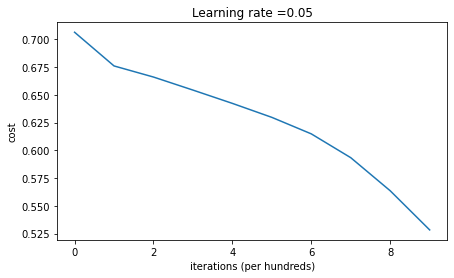

未优化 - 代价函数:  0.5282867891550271
未优化 精确度
===== Accuracy: 89.60000000000001% =====


In [26]:
# 未优化
Layers = [train_X.shape[0], 10, 2, 1]
NN = NN_Model(train_X, train_Y, Layers, 0.05, 1000)
params = NN.training_GD()

predict(train_X, train_Y, params, text = '未优化 精确度')

# 1 - Momentum

## 1.1 - 步骤
1. $\frac{dJ}{dw}$, $\frac{dJ}{db}$

2. $V_{dw} = \beta v_{dw} + (1 - \beta)$$\frac{dJ}{dw}$
类似 $v_{\theta} = \beta v_{\theta} + (1 - \beta)\theta_t$

3. $V_{db} = \beta v_{db} + (1 - \beta)$$\frac{dJ}{db}$

4. $w = w - \alpha V_{dw}$
5. $b = b - \alpha V_{db}$

## 1.2 - update_backward_propagation
- $V_{dw}$, $V_{db}$
- $\beta$

![image](https://wx2.sinaimg.cn/mw1024/701c57e5ly1gdhku2oxj9j217m0ng7ie.jpg)

## 1.3 - update
```python
def init_velocity (params, L_len):
    # 创建和 W, b一样的矩阵, 创建 Velocity
    """
    np.zeros_like([[5, 1, 1], [5, 1, 1]])
    return [[0 0 0], [0 0 0]]
    """
    Velocity = {}
    for i in range(1, L_len):
        Velocity['dJ_dW' + str(i)] = np.zeros_like(params['W' + str(i)])
        Velocity['dJ_db' + str(i)] = np.zeros_like(params['b' + str(i)])
    return Velocity

def update_derivatives_momentum (params, grads, alpha, L_len, Velocity, beta = 0.9):
    """
    𝑉_𝑑𝑤 = 𝛽 𝑉_𝑑𝑤 + (1−𝛽) 𝑑𝐽_𝑑𝑤  
    𝑤=𝑤 − 𝛼 𝑉_𝑑𝑤
    """
    for l in range(1, L_len):
        # dJ_dw, dJ_dw
        dJ_dW = grads['dJ_dW' + str(l)]
        dJ_db = grads['dJ_db'+ str(l)]
        
        # V_dJ_dw, V_dJ_db
        V_dJ_dw = Velocity['dJ_dW' + str(l)]
        V_dJ_db = Velocity['dJ_db' + str(l)]
        
        # V_dJ_dw = beta * V_dJ_dw + (1 - beta) * dJ_dw
        # V_dJ_db = beta * V_dJ_db + (1 - beta) * dJ_db
        Velocity['dJ_dW' + str(l)] = beta * V_dJ_dw + (1 - beta) * dJ_dW
        Velocity['dJ_db' + str(l)] = beta * V_dJ_db + (1 - beta) * dJ_db

        params['W' + str(l)] -= alpha * Velocity['dJ_dW' + str(l)]
        params['b' + str(l)] -= alpha * Velocity['dJ_db' + str(l)]
    
    return params

```

======= Momentum ======
======= Momentum - 1. 新增 Velocity ======
======= Momentum - 2. 修改 update_derivatives_momentum ======


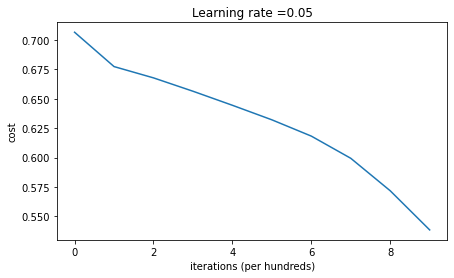

Momentum - 代价函数:  0.5385991655957427
Momentum 精确度
===== Accuracy: 88.4% =====


In [27]:
# Momentum
Layers = [train_X.shape[0], 10, 2, 1]
NN_Momentum = NN_Model(train_X, train_Y, Layers, 0.05, 1000)

# If $\beta = 0$, then this just becomes standard gradient descent without momentum.
params = NN_Momentum.training_Momentum(0.9)

predict(train_X, train_Y, params, text = 'Momentum 精确度')

# 2 - Adam

Momentum
1. $\frac{dJ}{dw}$, $\frac{dJ}{db}$

2. $V_{dw} = \beta v_{dw} + (1 - \beta)$$\frac{dJ}{dw}$
类似 $v_{\theta} = \beta v_{\theta} + (1 - \beta)\theta_t$

3. $V_{db} = \beta v_{db} + (1 - \beta)$$\frac{dJ}{db}$

4. $w = w - \alpha V_{dw}$
5. $b = b - \alpha V_{db}$

RMSprop
- 横向加速减少: w可以快速横轴上的减少
- 竖向缓慢减少: b可以减缓纵轴上的摆动


1. $S_{dw} = \beta S_{dw} + (1 - \beta)$$\frac{dJ}{dw}^2$
2. $S_{db} = \beta S_{db} + (1 - \beta)$$\frac{dJ}{db}^2$
3. $w = w - \alpha \sqrt{\frac{dJ/dw}{(S_{dw})}}$
4. $b = b - \alpha \sqrt{\frac{dJ/db}{(S_{db})}}$


Adam
1. $\frac{dJ}{dw}$, $\frac{dJ}{db}$

2. $V_{dw} = \beta_1 v_{dw} + (1 - \beta_1)$$\frac{dJ}{dw}$

3. $S_{dw} = \beta_2 S_{dw} + (1 - \beta_2)$$\frac{dJ}{dw}^t$

4. $V_{dw}^{correct} = \frac{V_{dw}}{1 - (\beta_1)^t}$

5. $S_{dw}^{correct} = \frac{S_{dw}}{1 - (\beta_2)^t}$


6. $w -= \alpha \frac{V_{dw}^{correct}}{\epsilon + \sqrt{S_{dw}^{correct}}}$


======= Adam ======
======= Adam - 1. 新增 Velocity, Square ======
======= Adam - 2. 修改 update_derivatives_Adam ======


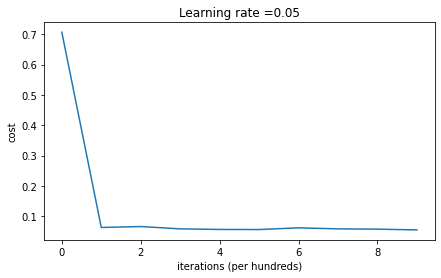

Momentum - 代价函数:  0.05506152076617827
Adam 精确度
===== Accuracy: 97.7% =====


In [28]:
# Adam
Layers = [train_X.shape[0], 10, 2, 1]
NN_Adam = NN_Model(train_X, train_Y, Layers, 0.05, 1000)
params = NN_Adam.training_Adam (beta1 = 0.9, beta2 = 0.999, t = 2)

predict(train_X, train_Y, params, text = 'Adam 精确度')


```python
# ====== Adam ====== 
def init_Adam (params, L_len):
    # 1. 创建Velocity, 创建Square
    Velocity, Square = {}, {}
    
    # 2. 创建初始化值为0 和 每层params.weights, params.bias一样尺寸
    for l in range(1, L_len):
        W, b = params['W' + str(l)], params['b' + str(l)]
        
        Velocity['dJ_dW' + str(l)] = np.zeros_like(W)
        Velocity['dJ_db' + str(l)] = np.zeros_like(b)
        
        Square['dJ_dW' + str(l)] = np.zeros_like(W)
        Square['dJ_db' + str(l)] = np.zeros_like(b)
    
    return Velocity, Square


def update_derivatives_Adam (params, grads, alpha, L_len, Velocity, Square, beta1 = 0.9, beta2 = 0.9, t = 2):
    Velocity_correct = {}
    Square_correct = {}
    epsilon = 1e-8
    
    for l in range(1, L_len):
        dJ_dW_i = 'dJ_dW' + str(l)
        dJ_db_i = 'dJ_db' + str(l)
        
        # 1. derivatives
        dJ_dW = grads[dJ_dW_i]
        dJ_db = grads[dJ_db_i]
        
        """
        𝑉𝑑𝑤=𝛽1 * V𝑑𝑤 + (1−𝛽1)  𝑑𝐽𝑑𝑤 
        𝑆𝑑𝑤=𝛽2 * 𝑆𝑑𝑤 + (1−𝛽2)  (𝑑𝐽𝑑𝑤)^2
        """
        # 2. V_dJ_dW, V_dJ_db
        Velocity[dJ_dW_i] = beta1 * Velocity[dJ_dW_i] + (1 - beta1) * dJ_dW
        Velocity[dJ_db_i] = beta1 * Velocity[dJ_db_i] + (1 - beta1) * dJ_db
        
        # 3. S_dJ_dW, S_dJ_db
        Square[dJ_dW_i] = beta2 * Square[dJ_dW_i] + (1 - beta2) * np.power(dJ_dW, 2)
        Square[dJ_db_i] = beta2 * Square[dJ_db_i] + (1 - beta2) * np.power(dJ_db, 2)
        
        # 4. Velocity_correct: V_dJ_dW, V_dJ_db
        """
        𝑉𝑐𝑜𝑟𝑟𝑒𝑐𝑡_𝑑𝐽_𝑑𝑤 = V_𝑑𝐽_𝑑𝑤 / 1−(𝛽1)^𝑡
        𝑆𝑐𝑜𝑟𝑟𝑒𝑐𝑡_𝑑𝐽_𝑑𝑤 = S_𝑑𝐽_𝑑𝑤 / 1−(𝛽2)^𝑡
        """
        Velocity_correct[dJ_dW_i] = Velocity[dJ_dW_i] / (1 - np.power(beta1, t))
        Velocity_correct[dJ_db_i] = Velocity[dJ_db_i] / (1 - np.power(beta1, t))
        
        # 5. Square_correct: S_dJ_dW, S_dJ_db
        Square_correct[dJ_dW_i] = Square[dJ_dW_i] / (1 - np.power(beta2, t))
        Square_correct[dJ_db_i] = Square[dJ_db_i] / (1 - np.power(beta2, t))
        
        # 6. Update derivatives
        """
        𝑤 −= a * Velocity_correct / e + sqrt(Square_correct)
        """
        params['W' + str(l)] -= alpha * Velocity_correct[dJ_dW_i] / (epsilon + np.sqrt(Square_correct[dJ_dW_i]))
        params['b' + str(l)] -= alpha * Velocity_correct[dJ_db_i] / (epsilon + np.sqrt(Square_correct[dJ_db_i]))
        
    return params
        
```

# 3 - Conclusions

| type | training accuracy |
| :--- | :----: |
| Gradient descent | 89.60% |
| Gradient descent with Momentum   | 88.00%     |
| Gradient descent with Adam   | 97.7%      |